In [1]:
# import packages

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import random
plt.style.use('ggplot')

%matplotlib inline


# py-statistics-1 Assignment Solutions

### Part 1: Sampling Population

Imagine that you are a data scientist working for a healthcare company who wants to know a obesity parameter X for the people living in San Francisco.

Assume that X follows this normal distribution:

import scipy.stats as stats
rv = stats.norm(150,10)
Plot the PDF of X. What is mean, median, and the 95 percentile of X?

Text(0, 0.5, 'Probability Density')

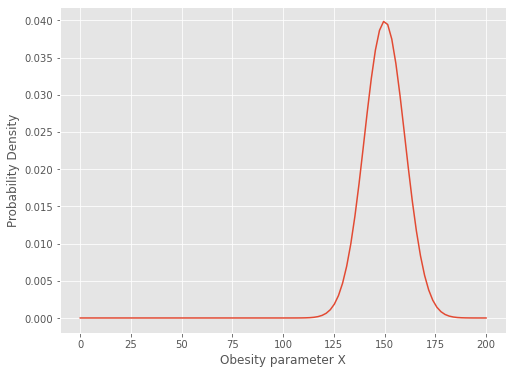

In [2]:
rv = stats.norm(150,10)

fig, ax = plt.subplots(figsize=(8,6))
x = np.linspace(0, 200, 100)
ax.plot(x, rv.pdf(x))
ax.set_xlabel('Obesity parameter X')
ax.set_ylabel('Probability Density')


In [3]:
# the mean, median and 95 percentile of X are:
rv.mean(), rv.median(), rv.ppf(95/100)

(150.0, 150.0, 166.44853626951473)

In [4]:
def plot_epdf_1d_sample(sample,ax, **options):
    """plot 1-D sample
    Args
    ----
        sample: 1-D np.array or a list of numbers
        ax: plt object e.g. fig, ax = plt.subplots(figsize=(8,6))
        
    return
    ------
        The empirical cdf of the 1-D data
    """
    # fit a cdf
    sns.distplot(sample, 
                 hist=False, 
                 kde=True, 
                 ax = ax,
                 **options)
    ax.set_xlabel('Sample Value')
    ax.set_ylabel('Probability Density')

C:\Users\fslal\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\fslal\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\fslal\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

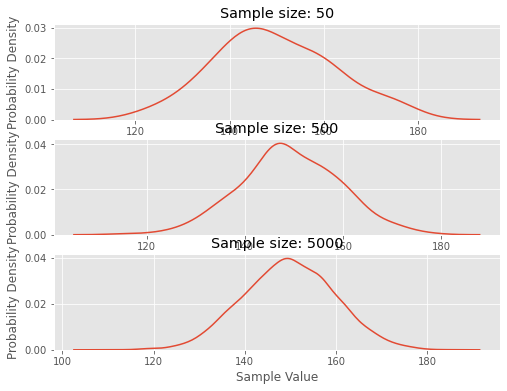

In [5]:
sizes = [50, 500, 5000]

fig, axs = plt.subplots(nrows=len(sizes), ncols=1, figsize=(8,6))
for i, size in enumerate(sizes):
    df = pd.read_csv(f'data/sample_{str(size)}.csv')
    sample = np.array(df['0'])
    plot_epdf_1d_sample(sample, axs[i])
    axs[i].set_title(f'Sample size: {size}')

The mean, median and 95 percentile for each sample are as following:

In [6]:
df = pd.DataFrame(columns = ['mean', 'median', '95-percentile'])
for size in sizes:
    df_sample = pd.read_csv(f'data/sample_{str(size)}.csv')
    sample = np.array(df_sample['0'])
    row = {'mean': np.mean(sample), 'median': np.median(sample), '95-percentile': np.percentile(sample, q=95)}
    df = df.append(row, ignore_index = True)
    
df.index = ['sample_'+str(size) for size in sizes]  

It seems that the bigger the sample size is, the better the estimated statistics approach the real population parameters.

## Part 2.1: Bootstrapping

Implement a bootstrap function to randomly draw with replacement from a given sample. The function should take a sample as a numpy ndarray and the number of resamples as an integer (default: 10000). The function should return a list of numpy ndarray objects, each ndarray is one bootstrap sample.

In [7]:
def bootstrap(sample, num_bootstraps=10000):
    """Draw bootstrap re-samples from the array sample.

    Parameters
    ----------
    sample: a np.array with shape (n, ). The data to draw the bootstrap samples from.
    
    num_bootstraps: int
      The number of bootstrap samples, each is built by sampling from sample with replacement.
    
    Returns
    -------
    bootstrap_samples: a list of np.ndarray with length num_bootstraps. The bootstrap resamples from sample.
    """
    # np.random.choise() only work for 1-D array, nothing else!
    #bootstrap_samples = [np.random.choice(sample, size=sample.shape[0], replace=True) for i in range(num_bootstraps)]
    if type(sample) != np.ndarray:
        sample = np.array(sample)

    if len(sample.shape) < 2:
        sample = sample[:, np.newaxis] # [:, np.newaxis] increases the dimension of arr from 1 to 2

    nrows = sample.shape[0]
    boot_samples = []
    for _ in range(num_bootstraps):
        row_inds = np.random.randint(nrows, size=nrows)
        # because of the [:, np.newaxis] above 
        # the following will is a 1-d numeric data with the same size as the input sample
        boot_sample = sample[row_inds, :]
        boot_samples.append(boot_sample)

    return boot_samples

In [8]:

# Create some random data to test our bootstrap func.
rand_data = np.random.randn(5)

booted_data = bootstrap(rand_data, num_bootstraps=3)

# Check that bootstrap is working as expected. booted_data is a list of arrays.
print(rand_data)
print(booted_data)

[ 0.24769028  0.07947724 -0.24873455 -0.22548189 -1.77162571]
[array([[-0.24873455],
       [-0.22548189],
       [ 0.24769028],
       [-0.24873455],
       [-0.22548189]]), array([[-1.77162571],
       [-1.77162571],
       [ 0.07947724],
       [-1.77162571],
       [ 0.07947724]]), array([[-0.22548189],
       [ 0.24769028],
       [-0.24873455],
       [-0.24873455],
       [-1.77162571]])]


## Part 2.2: Bootstrap to find Confidence Interval of Mean

Load the data data/productivity.txt.

In [9]:
productivity = np.loadtxt('data/productivity.txt')


Question: Why is it inappropriate to only report the mean difference in productivity as evidence to support the decision of changing all the monitors to Apple monitors in the company?

Answer: The mean difference in productivity is a point estimate from a sample of a larger population. This type of point estimate does not really tell us anything unless we have some measure of how certain it is, and often we use a confidence interval for that.

Implement a bootstrap_ci function to calculate the confidence interval of any sample statistic (in this case the mean). The function should take a sample, a function that computes the sample statistic, the number of resamples (default: 10000), and the confidence level (default: 0.95). The function should return the lower and upper bounds of the confidence interval and the bootstrap distribution of the test statistic.

In [10]:
def bootstrap_confidence_interval(sample, stat_function=np.mean, num_bootstraps=1000, ci=95):
    """Calculate the CI of chosen sample statistic using bootstrap sampling.

    CI = confidence interval

    Parameters
    ----------
    sample: Numpy array
        1-d numeric data

    stat_function: function, optional (default=np.mean)
        Function for calculating as sample statistic on data

    num_bootstraps: int, optional (default=1000)
        Number of bootstrap samples to create

    ci: int, optional (default=95)
        Percent of distribution encompassed by CI, 0<ci<100

    Returns
    -------
    tuple: lower_ci(float), upper_ci(float), bootstrap_samples_statistic(array)
        Lower and upper bounds of CI, sample stat from each bootstrap sample
    """
    boostrap_samples = bootstrap(sample, num_bootstraps)
    bootstrap_samples_stat = list(map(stat_function, boostrap_samples))
    low_bound = (100. - ci) / 2
    high_bound = 100. - low_bound
    lower_ci, upper_ci = np.percentile(bootstrap_samples_stat,
                                       [low_bound, high_bound])
    return lower_ci, upper_ci, bootstrap_samples_stat

In [11]:

lower_ci, upper_ci, bootstrap_means_prod = bootstrap_confidence_interval(productivity, ci=95)
print("The 95% bootstrapped CI of the mean: ({}, {})".format(lower_ci, upper_ci))

The 95% bootstrapped CI of the mean: (0.039900000000000116, 10.220299999999998)




Plot the bootstrap distribution of the means in a histogram.

Text(0.5, 0, 'Difference in Productivity')

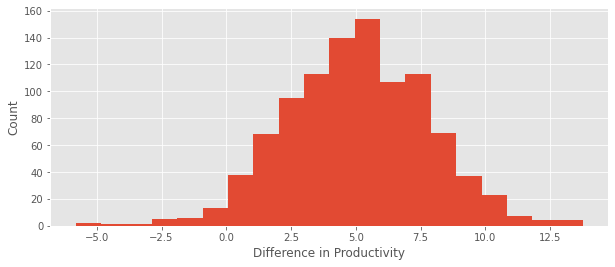

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.hist(bootstrap_means_prod, bins=20)
ax.set_ylabel('Count')
ax.set_xlabel('Difference in Productivity')

Question: Based on the bootstrap confidence interval, what conclusions can you draw? What about if a 90% confidence interval were used instead?

Answer: Based on the 95% bootstrap CI, we are unable to conclude that the new monitors would lead to an productivity improvement in the population since the CI includes zero in the differences in productivity, implying possibility of no improvement or even reduction in performance.

Questions: What about if a 90% confidence interval were used instead?

Answer:

In [13]:
lower_ci, upper_ci, bootstrap_samples_stat = bootstrap_confidence_interval(productivity, ci=90)
print("The 90% bootstrapped CI of the mean: ({}, {})".format( lower_ci, upper_ci))
print("Your results would be slightly different")

The 90% bootstrapped CI of the mean: (0.7343999999999997, 9.5648)
Your results would be slightly different


Your results would be slightly different
Here we see that the CI does not include 0, so we could conclude that there is statistical evidence that the monitors lead to an improvement. However, we are allowing for a larger chance of a Type I Error (To be discussed in more detail with Frequentist Hypothesis Testing).

Question: Suppose there are 100 programmers in the company. The cost of changing a monitor is 500 dollars and the increase of one unit of productivity is worth 2,000 dollars, would you recommend switching the monitors? State the assumptions you are making and show your work.

Answer: If you want 95% confidence in your decision the answer is obviously a no go since there is a potential decrease in production. However, if we use the 90% CI to establish a minimum expected average improvement of 0.6 units (which should be close to the value printed above) this implies a net improvement of 0.60 units/person 100 people = 60 units which has a value of $2000</em>60 = $120,000 while the cost of new monitors would be $500*100 = $50,000 leading to a profit of approx $70,000 ==> they should buy the new monitors.

## Part 2.3: Bootstrap to find Confidence Interval of Correlation

Correlation between LSAT scores and law school grade point average.

Load the data data/law_sample.txt

In [14]:
## Change path to law_sample.txt
law_sample = np.loadtxt('data/law_sample.txt')
law_sample

array([[576.  ,   3.39],
       [635.  ,   3.3 ],
       [558.  ,   2.81],
       [578.  ,   3.03],
       [666.  ,   3.44],
       [580.  ,   3.07],
       [555.  ,   3.  ],
       [661.  ,   3.43],
       [651.  ,   3.36],
       [605.  ,   3.13],
       [653.  ,   3.12],
       [575.  ,   2.74],
       [545.  ,   2.76],
       [572.  ,   2.88],
       [594.  ,   2.96]])

In [15]:
law_sample.dtype

dtype('float64')

In [16]:

corr, p_value = stats.pearsonr(law_sample[:, 0], law_sample[:, 1])
print(f"The correlation is: {corr:2.2f}")

The correlation is: 0.78



Bootstrapped Estimate of the Correlation

In [17]:
lower_ci, upper_ci, bootstrap_corr_law = bootstrap_confidence_interval(
    law_sample, 
    stat_function=lambda x: stats.pearsonr(x[:, 0], x[:, 1])[0],
    num_bootstraps=10000, 
    ci=95)
print("Bootstrapped 95% CI of Law school correlation coeff: ({:2.2f}, {:2.2f})".format(lower_ci, upper_ci))
print("Bootstrapped 95% CI does not contain 0, so LSAT seems predictive of GPA")

Bootstrapped 95% CI of Law school correlation coeff: (0.46, 0.96)
Bootstrapped 95% CI does not contain 0, so LSAT seems predictive of GPA


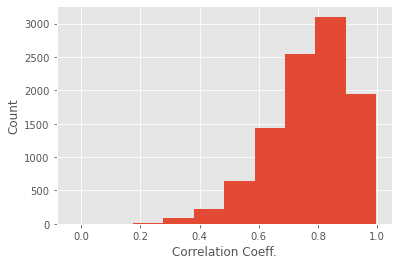

In [18]:
plt.hist(bootstrap_corr_law)
plt.xlabel('Correlation Coeff.')
plt.ylabel('Count');

Recall from the sprint that the shape of this distribution should make us suspicious, due to its asymmetry, and we might want to look into: Studentized Bootstrap & Bias-Corrected Bootstrap

- Load in the population data and verify the population correlation is in the 95% CI

In [19]:
law_all = np.loadtxt('data/law_all.txt')
corr_coeff, p_val = stats.pearsonr(law_all[:, 0], law_all[:, 1])
print("Population-wide LSAT and GPA correlation and P-value: {:2.2f}".format(corr_coeff))

Population-wide LSAT and GPA correlation and P-value: 0.76
